### kaggle タイタニック生存者
```
kaggle competitions download -c titanic
```

In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Common function

In [56]:
def plot_bar(x_df: pd.Series , y_df:pd.Series):
    if len(x_df.drop_duplicates()) > 100:
        return
    col_name  : str = x_df.name
    if len(x_df.drop_duplicates()) >30:
        plt.figure(figsize=(60 , 10))
    else:
        plt.figure(figsize=(10,5))
    sns.barplot(x=x_df.sort_values() , y=y_df )
    plt.title(f"Survied Rate by {col_name}")
    plt.show()    



### データの読み込み

In [57]:

train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")
train_df.info()
# sns.barplot(x=train_df["Sex"] , y=train_df["Survived"] )
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


----------------------------


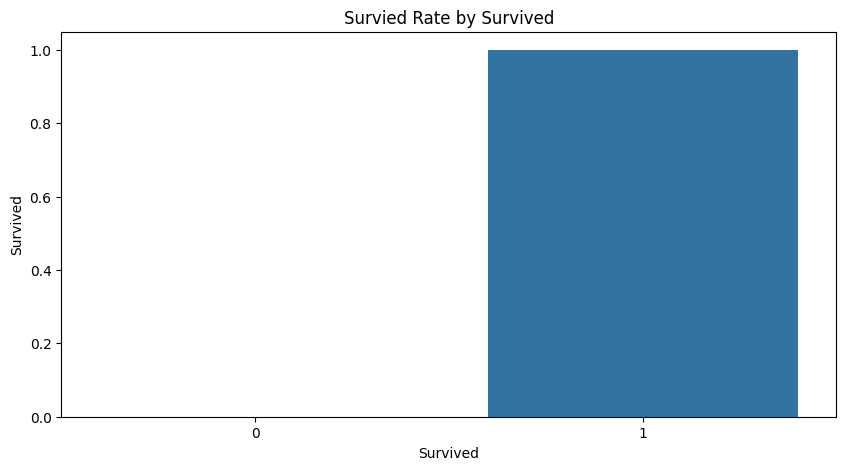

----------------------------


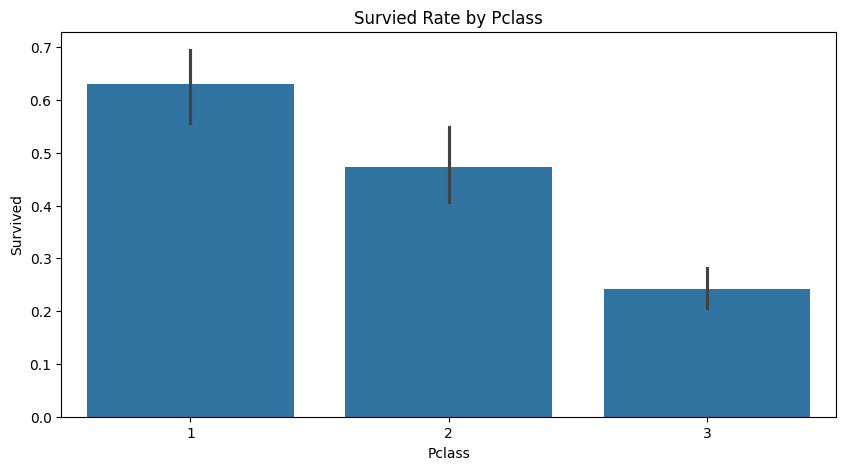

----------------------------


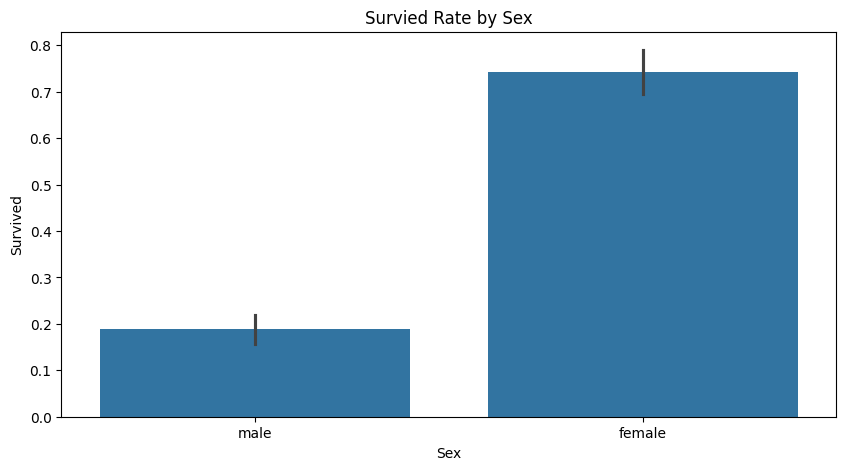

----------------------------


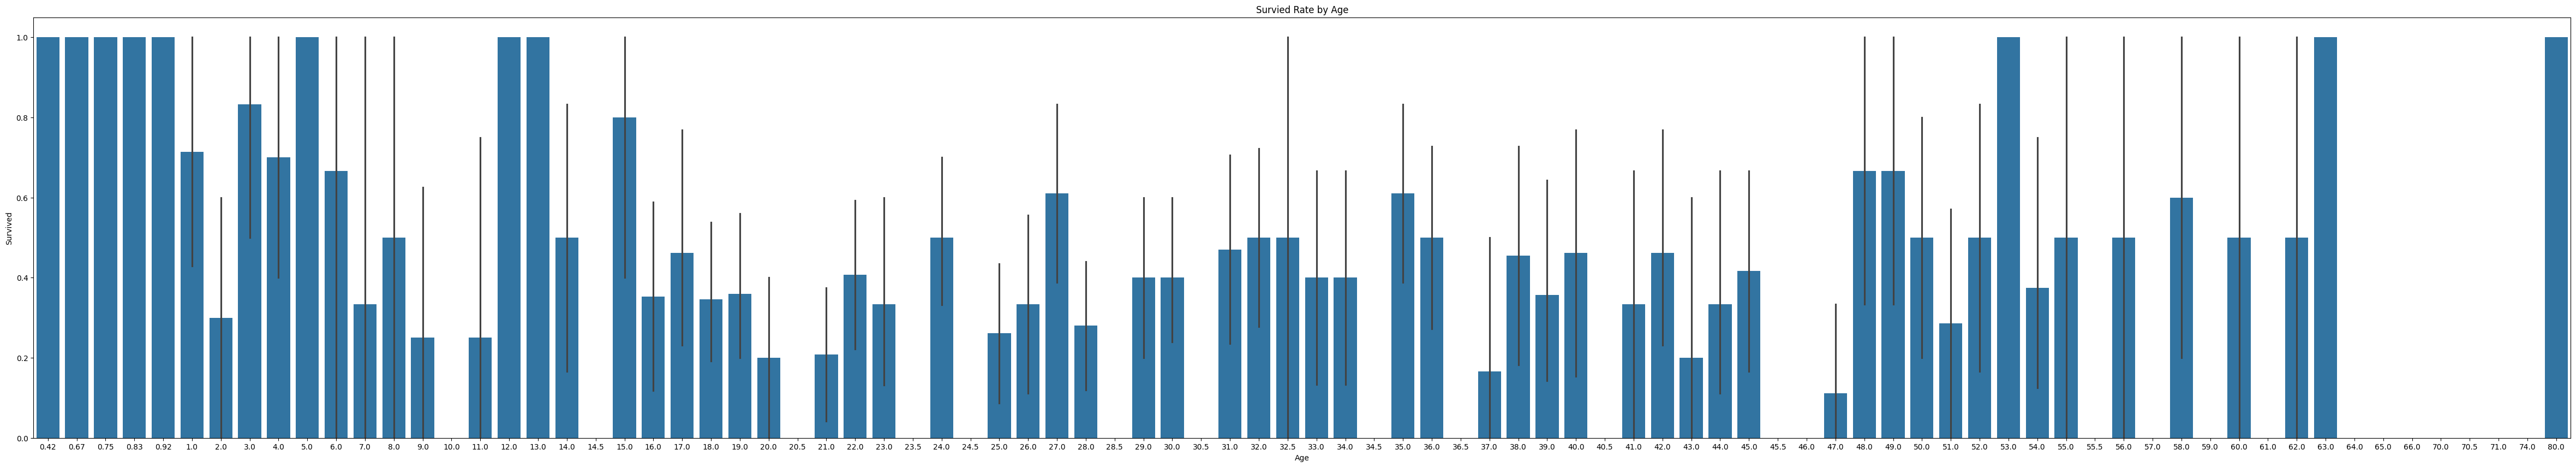

----------------------------


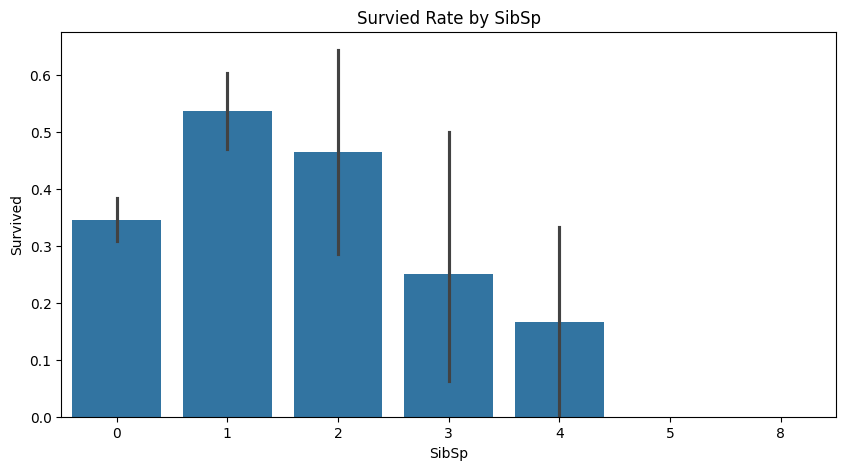

----------------------------


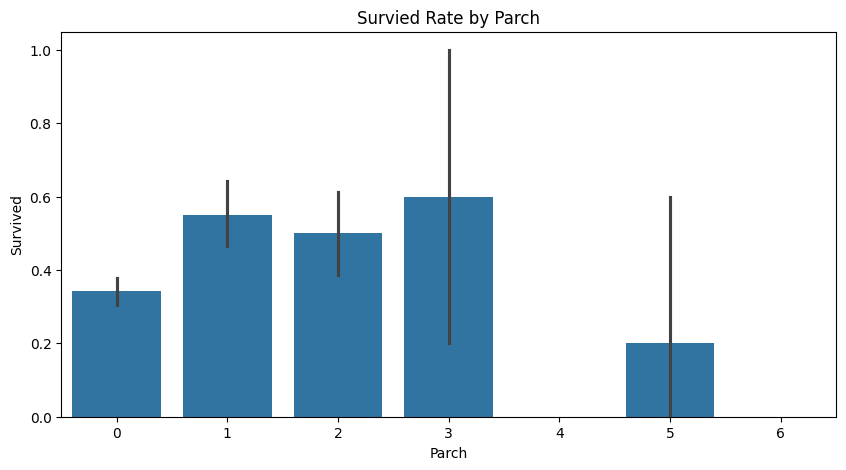

----------------------------


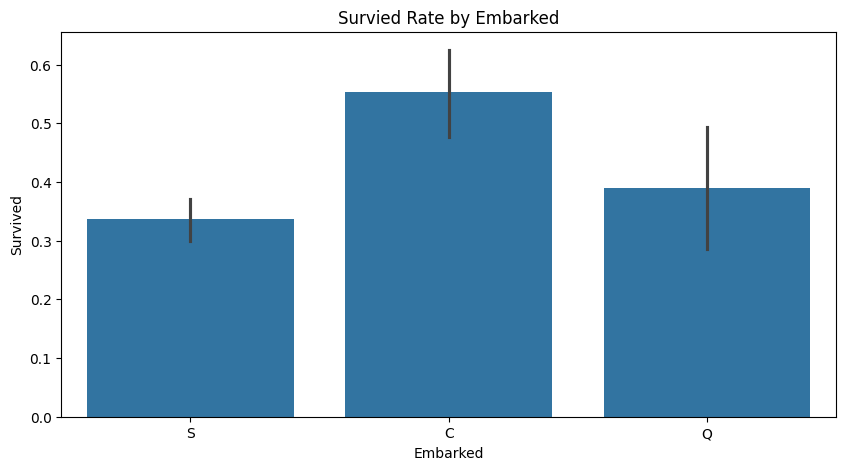

In [58]:
# train_df.value_counts()

all_col_map = {}
target_col_map = {}
dummie_col_list = []
train_cols_list : list = train_df.columns.to_list()
for col in train_cols_list:
    if len(train_df[col].drop_duplicates()) > 100:
        continue
    print("----------------------------")
    plot_bar(x_df=train_df[col] , y_df=train_df["Survived"])
    dummie_col_list.append(col)



### 年齢だけは相関が把握しきれていないので、分布図に起こす

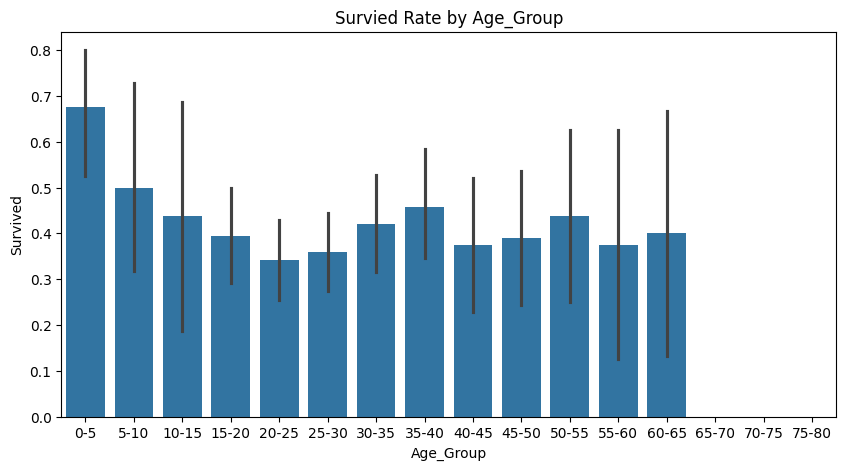

In [59]:
INTERVAL_BIN = 5

max_age : int = train_df["Age"].max().astype(int)
min_age : int = train_df["Age"].min().astype(int)
bins : list = [num for num in range(min_age , max_age  + INTERVAL_BIN , INTERVAL_BIN)]
labels : list = [f"{bins[i]}-{bins[i + 1]}" for i in range(len(bins) -1)]
train_df["Age_Group"]  = pd.cut(train_df["Age"] , bins=bins , labels=labels , right=False)

plot_bar(train_df["Age_Group"] , train_df["Survived"])
age_group_mode : str = train_df["Age_Group"].mode().values[0]
train_df["Age_Group"] = train_df["Age_Group"].fillna(age_group_mode)

## この結果をもとに年齢区間のdummy変数を作成する
age_dummies = pd.get_dummies(train_df["Age_Group"] , prefix="Age" , dtype=int)


In [63]:
excluede_dummies = [
    "Survived" ,
    "Age",
    # "Embarked",
    ]
new_dummie_col_list = [col for col in dummie_col_list if col not in excluede_dummies]
new_dummie_col_list

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

## ほかカラムの前処理

In [68]:
# train_df["Cabin"] = train_df["Cabin"].fillna("")
train_df["Embarked"] = train_df["Embarked"].fillna(
    train_df["Embarked"].mode().values[0]
)


tmp_train_df = train_df[new_dummie_col_list]
nan_cols = tmp_train_df.columns[tmp_train_df.isna().sum() > 0].to_list()
nan_cols

[]

In [ ]:



def pre_exec(dummie_list : list , dummy_df : pd.DataFrame) -> pd.DataFrame:
    dummy_df = train_df[dummy_cols_list]
    dummy_df = pd.get_dummies(train_df[dummy_cols_list] , drop_first=True)
    dummy_df = dummy_df.replace({True : 1,
                                False : 0})
    dummy_df = dummy_df.rename(columns=
                            {"Sex_male" : "Sex"})
    dummy_df.insert(0 , "intercept" , 1)
    return dummy_df

y = train_df["Survived"]
x = pre_exec(dummy_cols_list=dummy_cols_list , dummy_df=train_df)
md = sm.OLS(y , x)
model = md.fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     68.82
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           1.07e-87
Time:                        00:23:48   Log-Likelihood:                -405.89
No. Observations:                 891   AIC:                             829.8
Df Residuals:                     882   BIC:                             872.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2968      0.276      4.704      0.0

C:\Users\shino\AppData\Local\Temp\ipykernel_12104\1216051528.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dummy_df = dummy_df.replace({True : 1,


0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

## 予測を行うテストデータの前処理

In [ ]:

predict_x = pre_exec(dummy_cols_list=dummy_cols_list , dummy_df=test_df)
predict_values = model.predict(predict_x)
# しきい値を 0.5 に設定し、0 or 1 に変換
predict_binary = (predict_values >= 0.5).astype(int)

merge_df = pd.concat([test_df["PassengerId"] , predict_binary]  , axis=1)
merge_df = merge_df.rename(columns={0 : "Survived"})
merge_df.sort_values(by="PassengerId")


os.makedirs("./out" , exist_ok=True)

merge_df.to_csv("./out/result.csv", index=False)
merge_df


C:\Users\shino\AppData\Local\Temp\ipykernel_12104\1216051528.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dummy_df = dummy_df.replace({True : 1,


,PassengerId,Survived
0,892.0,0
1,893.0,1
2,894.0,1
3,895.0,1
4,896.0,0
...,...,...
886,NaN,0
887,NaN,1
888,NaN,1
889,NaN,0
